## Build a binary classification model for each device

In [22]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from time import time
import seaborn as sns

from tqdm import tqdm

from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from data_functions import load_month_data
import classes.EnsembleClassifier as ec
from importlib import reload
reload(ec)

LOCAL_DATA_DIR = '../data-monthly'

DEVICE_LIST = ['sony_bravia', 'google_home_gen1', 'au_wireless_adapter',
       'sony_smart_speaker', 'amazon_echo_gen2', 'jvc_kenwood_cu-hb1',
       'au_network_camera', 'powerelectric_wi-fi_plug', 'qrio_hub',
       'planex_smacam_pantilt', 'philips_hue_bridge', 'line_clova_wave',
       'i-o_data_qwatch', 'planex_smacam_outdoor',
       'jvc_kenwood_hdtv_ip_camera', 'bitfinder_awair_breathe_easy',
       'irobot_roomba', 'panasonic_doorphone', 'xiaomi_mijia_led',
       'link_japan_eremote', 'nature_remo', 'sony_network_camera',
       'candy_house_sesami_wi-fi_access_point', 'planex_camera_one_shot!',
       'mouse_computer_room_hub']

In [23]:
# The 28 features used in the 2022 paper (Dynamic inference of IoT...)
PAPER_FEATURES = [
    # forward flow features
    'PacketCount',
    'BytesCount',
    'SmallPktCount',
    'LargePktCount',
    'NonEmptyPktCount',
    'DataByteCount',
    'AvgIAT',
    'FirstNonEmptyPktSize',
    'MaxPktSize',
    'StdevPayloadSize',
    'StdevIAT',
    # reverse flow features
    'reversePacketCount',
    'reverseBytesCount',
    'reverseSmallPktCount',
    'reverseLargePktCount',
    'reverseNonEmptyPktCount',
    'reverseDataByteCount',
    'reverseAvgIAT',
    'reverseFirstNonEmptyPktSize',
    'reverseMaxPktSize',
    'reverseStdevPayloadSize',
    'reverseStdevIAT',
    # Binary protocol features
    'HTTP', 'HTTPS', 'DNS', 'NTP', 'TCP_others', 'UDP_others'
]

### Helper functions

In [33]:
def correlation(df):
    # Remove correlated variables to improve convergence
    corr_matrix = df.corr(numeric_only=True)

    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
    plt.title('Correlation Matrix')
    plt.show()


def metrics(model, X_train, y_train, X_test, y_test, show_matrix=False):
    """
    Args:
        model (sklearn model): trained model
        X_train (np.array): training features
        y_train (np.array): training target
        X_test (np.array): test features
        y_test (np.array): test target
        show_matrix (bool): whether to show the confusion matrix
    """

    print(f'Dataset:')
    print(f'> {format(X_train.shape[0], ",d")} samples in training set')
    print(f'> {format(X_test.shape[0], ",d")} samples in test set')
    print(f'> {X_train.shape[1]} features included')

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    train_acc = round(accuracy_score(y_train, y_train_pred), 4)
    test_acc = round(accuracy_score(y_test, y_test_pred), 4)
    print(f"Accuracy: {train_acc} (train), {test_acc} (test)", )

    train_f1 = round(f1_score(y_train, y_train_pred), 4)
    test_f1 = round(f1_score(y_test, y_test_pred), 4)
    print(f"F1 score: {train_f1} (train), {test_f1} (test)")

    if show_matrix:
        cm = confusion_matrix(y_test, y_test_pred)
        plt.figure(figsize = (4,3))
        sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
        plt.title('Confusion Matrix on Test Data')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.show()


def train_test_split_for_device(df, device, test_prop, nrows_train=None, random_state=None):
    """
    Given the full dataframe for a month, splits the data into training and test
    sets for a model to predict a specific device.

    Args:
        df (pd.DataFrame): full dataframe for a month. Must include 'device' column
        device (str): device to predict (exactly as named in the data)
        test_prop (float): proportion of data to reserve for testing
        nrows_train (int): number of rows to use for training. Defualt is None,
                which uses all data. If specified, will sample that many rows
                from the full dataset with stratified sampling to ensure the
                class distribution remains the same. Use this parameter to
                reduce the overall dataset size and speed up training.
        random_state (int): seed
    """
    # make column for target device class
    df['device_' + device] = (df['device'] == device)

    # stratified sampling on target device class
    if nrows_train != None:
        nrows_overall = int(nrows_train / (1 - test_prop))
        frac = nrows_overall / len(df)
        sampled_df = df.groupby('device_' + device).sample(frac=frac, random_state=random_state)
    else:
        sampled_df = df

    device_cols = [col for col in sampled_df.columns if 'device' in col]
    y = sampled_df['device_' + device]
    X = sampled_df.drop(columns=device_cols)

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=test_prop, random_state=random_state)
    return X_train, X_test, y_train, y_test, scaler


def prepare_for_testing(df, columns, device, scaler):
    """
    Given a dataframe to be used for testing a model, splits it into X and y and
    scales the X values.
    """
    df['device_' + device] = df['device'] == device
    y = df['device_' + device]
    X = df[columns]
    X_scaled = scaler.transform(X)
    return X_scaled, y


def plot_monthly_performance(y_jul, y_pred_jul, y_aug, y_pred_aug, y_sep, y_pred_sep, y_oct, y_pred_oct):
    """
    Plots the average F1, weighted F1, and accuracy of the predictions made for
    each month.

    Args:
        y_{MONTH} (pd.Series): a label-encoded series of true labels
        y_pred_{MONTH} (pd.Series): a label-encoded series of predicted labels
    """
    f1_jul = f1_score(y_jul, y_pred_jul, average='macro')
    f1_aug = f1_score(y_aug, y_pred_aug, average='macro')
    f1_sep = f1_score(y_sep, y_pred_sep, average='macro')
    f1_oct = f1_score(y_oct, y_pred_oct, average='macro')
    average_f1s = [f1_jul, f1_aug, f1_sep, f1_oct]

    weighted_f1_jul = f1_score(y_jul, y_pred_jul, average='weighted')
    weighted_f1_aug = f1_score(y_aug, y_pred_aug, average='weighted')
    weighted_f1_sep = f1_score(y_sep, y_pred_sep, average='weighted')
    weighted_f1_oct = f1_score(y_oct, y_pred_oct, average='weighted')
    weighted_f1s = [weighted_f1_jul, weighted_f1_aug, weighted_f1_sep, weighted_f1_oct]

    acc_jul = accuracy_score(y_jul, y_pred_jul)
    acc_aug = accuracy_score(y_aug, y_pred_aug)
    acc_sep = accuracy_score(y_sep, y_pred_sep)
    acc_oct = accuracy_score(y_oct, y_pred_oct)
    accs = [acc_jul, acc_aug, acc_sep, acc_oct]

    fig, ax = plt.subplots()
    ax.plot(['July', 'August', 'September', 'October'], weighted_f1s, marker='o', label='Average F1 Score (weighted)')
    ax.plot(['July', 'August', 'September', 'October'], average_f1s, marker='o', label='Average F1 Score (macro)')
    ax.plot(['July', 'August', 'September', 'October'], accs, marker='o', label='Accuracy')
    ax.set_title('Performance of Binary Ensemble on Test Data After Training on July')
    ax.set_ylabel('Score')
    ax.set_ylim(-0.05,1.05)
    ax.legend()
    plt.show()


def test_over_months(ens, jul_test, aug, sep, oct, print_classification_reports=True):
    """
    Args:
        jul_test (pd.DataFrame): Unseen July data. Must contain the same columns
                as the training data as well as the target column.
        aug, sep, oct (pd.DataFrame): August/September/October data. Must contain
                the same columns as the training data as well as the target column.
    """
    encoder = LabelEncoder()
    encoder.fit(DEVICE_LIST)

    print('JULY:\n-----')
    res_jul = ens.predict(jul_test.drop(columns=['device']))
    y_test_jul = encoder.transform(jul_test['device'])
    y_pred_jul = encoder.transform(res_jul)
    if print_classification_reports:
        print(classification_report(y_test_jul, y_pred_jul, target_names=DEVICE_LIST, zero_division=np.nan))

    print('AUGUST:\n-------')
    res_aug = ens.predict(aug.drop(columns=['device']))
    y_aug = encoder.transform(aug['device'])
    y_pred_aug = encoder.transform(res_aug)
    if print_classification_reports:
        print(classification_report(y_aug, y_pred_aug, target_names=DEVICE_LIST, zero_division=np.nan))

    print('SEPTEMBER:\n----------')
    res_sep = ens.predict(sep.drop(columns=['device']))
    y_sep = encoder.transform(sep['device'])
    y_pred_sep = encoder.transform(res_sep)
    if print_classification_reports:
        print(classification_report(y_sep, y_pred_sep, target_names=DEVICE_LIST, zero_division=np.nan))

    print('OCTOBER:\n--------')
    res_oct = ens.predict(oct.drop(columns=['device']))
    y_oct = encoder.transform(oct['device'])
    y_pred_oct = encoder.transform(res_oct)
    if print_classification_reports:
        print(classification_report(y_oct, y_pred_oct, target_names=DEVICE_LIST, zero_division=np.nan))

    plot_monthly_performance(y_test_jul, y_pred_jul, y_aug, y_pred_aug, y_sep, y_pred_sep, y_oct, y_pred_oct)

### 25 binary random forest

In [26]:
july = pd.read_csv(f'data_reduced/july_paper_features_unique.csv')
aug = pd.read_csv(f'data_reduced/august_paper_features_unique.csv') # contains 25 NaNs ??
sep = pd.read_csv(f'data_reduced/september_paper_features_unique.csv')
oct = pd.read_csv(f'data_reduced/october_paper_features_unique.csv')

aug = aug.dropna()

#### 1) On reduced (paper columns) dataset, no imbalanced class strategy

In [ ]:
# Train model on July data (reserving some from this month for testing too)
X_train, X_test, y_train, y_test = train_test_split(july[PAPER_FEATURES], july['device'], test_size=0.2, random_state=42)

start = time()
ens = ec.BinaryClassifierEnsemble()
ens.fit(X_train, y_train)
end = time()
print(f'Training took {end-start:.2f} seconds')

NameError: name 'BinaryClassifierEnsemble' is not defined

JULY:
-----
Running inference...


100%|██████████| 25/25 [00:08<00:00,  3.06it/s]


                                       precision    recall  f1-score   support

                          sony_bravia       0.99      0.99      0.99      4502
                     google_home_gen1       0.85      0.78      0.82      2366
                  au_wireless_adapter       1.00      0.97      0.98     11340
                   sony_smart_speaker       1.00      1.00      1.00       711
                     amazon_echo_gen2       1.00      0.98      0.99       245
                   jvc_kenwood_cu-hb1       0.98      0.95      0.96     13944
                    au_network_camera       0.90      0.70      0.78      1015
             powerelectric_wi-fi_plug       0.73      0.55      0.63       617
                             qrio_hub       0.97      0.90      0.93      2957
                planex_smacam_pantilt       0.47      0.28      0.35       737
                   philips_hue_bridge       0.95      0.85      0.90      1072
                      line_clova_wave       0.77   

100%|██████████| 25/25 [00:19<00:00,  1.27it/s]


                                       precision    recall  f1-score   support

                          sony_bravia       0.99      0.99      0.99     19041
                     google_home_gen1       0.65      0.45      0.53      4466
                  au_wireless_adapter       1.00      0.97      0.98     46266
                   sony_smart_speaker       1.00      0.99      1.00      2789
                     amazon_echo_gen2       1.00      0.31      0.47      3233
                   jvc_kenwood_cu-hb1       0.98      0.98      0.98     58657
                    au_network_camera       0.99      0.67      0.80      5182
             powerelectric_wi-fi_plug       0.92      0.45      0.60      2726
                             qrio_hub       0.94      0.46      0.62      5640
                planex_smacam_pantilt       0.37      0.31      0.34      3647
                   philips_hue_bridge       0.98      0.85      0.91      7688
                      line_clova_wave       0.82   

100%|██████████| 25/25 [00:17<00:00,  1.39it/s]


                                       precision    recall  f1-score   support

                          sony_bravia       0.99      0.97      0.98     19824
                     google_home_gen1       0.55      0.46      0.50      4098
                  au_wireless_adapter       1.00      0.98      0.99     64348
                   sony_smart_speaker       1.00      1.00      1.00      2785
                     amazon_echo_gen2       1.00      0.57      0.73      1903
                   jvc_kenwood_cu-hb1       0.98      0.93      0.95     55371
                    au_network_camera       0.99      0.71      0.82      5107
             powerelectric_wi-fi_plug       0.97      0.46      0.62      2661
                             qrio_hub       0.98      0.50      0.66      5706
                planex_smacam_pantilt       0.34      0.33      0.34      3590
                   philips_hue_bridge       0.97      0.95      0.96      5952
                      line_clova_wave       0.69   

100%|██████████| 25/25 [00:09<00:00,  2.58it/s]


                                       precision    recall  f1-score   support

                          sony_bravia       0.99      0.99      0.99      6904
                     google_home_gen1       0.55      0.41      0.47      1614
                  au_wireless_adapter       1.00      0.98      0.99     22689
                   sony_smart_speaker       0.95      0.99      0.97      1069
                     amazon_echo_gen2       0.92      0.00      0.00     11945
                   jvc_kenwood_cu-hb1       0.97      0.86      0.91     11709
                    au_network_camera       1.00      0.77      0.87      2430
             powerelectric_wi-fi_plug       1.00      0.50      0.67       841
                             qrio_hub       0.97      0.58      0.73      2044
                planex_smacam_pantilt       0.46      0.28      0.35      1438
                   philips_hue_bridge       0.81      0.89      0.85      1485
                      line_clova_wave       0.89   

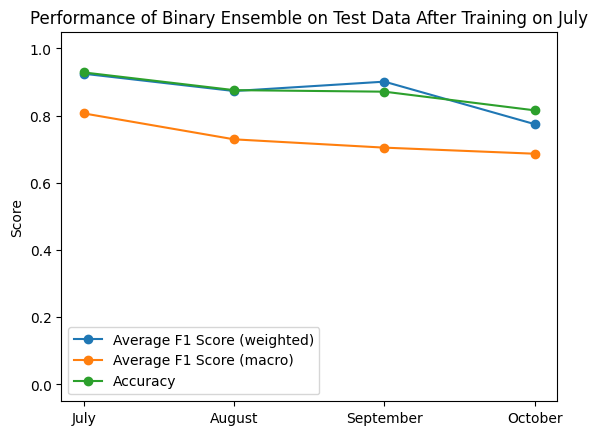

In [ ]:
test_over_months(ens, pd.concat([X_test, y_test], axis=1), aug, sep, oct, True)

# Pretty good across the board. Looking at classification report, devices with
# low number of samples have basically immediate drop in performance from train
# (july) to test (aug, sep, oct).

#### 2) Weight samples to for class balance

In [51]:
# "We assign a weight to each class, with the minority class given larger
# weight (i.e., higher misclassification cost)."

df = july
# df = july.groupby('device', group_keys=False).apply(lambda x: x.sample(frac=0.01))

# Train model on July data (reserving some from this month for testing too)
X_train, X_test, y_train, y_test = train_test_split(df[PAPER_FEATURES], df['device'], test_size=0.2, random_state=14, stratify=df['device'])

start = time()
ens = BinaryClassifierEnsemble(weight_classes=True)
ens.fit(X_train, y_train)
end = time()
print(f'Training took {end-start:.2f} seconds')

Fitting models...


100%|██████████| 25/25 [06:18<00:00, 15.15s/it]

Training took 378.87 seconds


JULY:
-----
Running inference...


100%|██████████| 25/25 [00:09<00:00,  2.65it/s]


                                       precision    recall  f1-score   support

                          sony_bravia       0.99      0.99      0.99      4494
                     google_home_gen1       0.79      0.79      0.79      2308
                  au_wireless_adapter       0.98      0.98      0.98     11371
                   sony_smart_speaker       1.00      1.00      1.00       705
                     amazon_echo_gen2       1.00      0.99      1.00       245
                   jvc_kenwood_cu-hb1       0.96      0.96      0.96     13778
                    au_network_camera       0.69      0.72      0.71      1063
             powerelectric_wi-fi_plug       0.65      0.61      0.63       585
                             qrio_hub       0.89      0.89      0.89      2995
                planex_smacam_pantilt       0.35      0.32      0.34       741
                   philips_hue_bridge       0.90      0.88      0.89      1067
                      line_clova_wave       0.71   

100%|██████████| 25/25 [00:23<00:00,  1.07it/s]


                                       precision    recall  f1-score   support

                          sony_bravia       0.99      0.99      0.99     19041
                     google_home_gen1       0.55      0.46      0.50      4466
                  au_wireless_adapter       0.99      0.97      0.98     46266
                   sony_smart_speaker       0.99      1.00      1.00      2789
                     amazon_echo_gen2       1.00      0.31      0.47      3233
                   jvc_kenwood_cu-hb1       0.97      0.98      0.97     58657
                    au_network_camera       0.94      0.69      0.80      5182
             powerelectric_wi-fi_plug       0.77      0.48      0.59      2726
                             qrio_hub       0.77      0.49      0.60      5640
                planex_smacam_pantilt       0.32      0.36      0.34      3647
                   philips_hue_bridge       0.98      0.87      0.92      7688
                      line_clova_wave       0.70   

100%|██████████| 25/25 [00:21<00:00,  1.15it/s]


                                       precision    recall  f1-score   support

                          sony_bravia       0.99      0.98      0.98     19824
                     google_home_gen1       0.49      0.46      0.48      4098
                  au_wireless_adapter       0.99      0.98      0.99     64348
                   sony_smart_speaker       0.99      1.00      0.99      2785
                     amazon_echo_gen2       0.98      0.58      0.73      1903
                   jvc_kenwood_cu-hb1       0.97      0.93      0.95     55371
                    au_network_camera       0.97      0.72      0.82      5107
             powerelectric_wi-fi_plug       0.89      0.49      0.63      2661
                             qrio_hub       0.89      0.52      0.65      5706
                planex_smacam_pantilt       0.29      0.37      0.33      3590
                   philips_hue_bridge       0.97      0.95      0.96      5952
                      line_clova_wave       0.56   

100%|██████████| 25/25 [00:10<00:00,  2.28it/s]


                                       precision    recall  f1-score   support

                          sony_bravia       0.96      0.99      0.98      6904
                     google_home_gen1       0.52      0.43      0.47      1614
                  au_wireless_adapter       1.00      0.98      0.99     22689
                   sony_smart_speaker       0.95      0.99      0.97      1069
                     amazon_echo_gen2       0.87      0.00      0.00     11945
                   jvc_kenwood_cu-hb1       0.95      0.87      0.91     11709
                    au_network_camera       0.94      0.79      0.86      2430
             powerelectric_wi-fi_plug       1.00      0.52      0.68       841
                             qrio_hub       0.88      0.59      0.70      2044
                planex_smacam_pantilt       0.44      0.29      0.35      1438
                   philips_hue_bridge       0.79      0.90      0.84      1485
                      line_clova_wave       0.88   

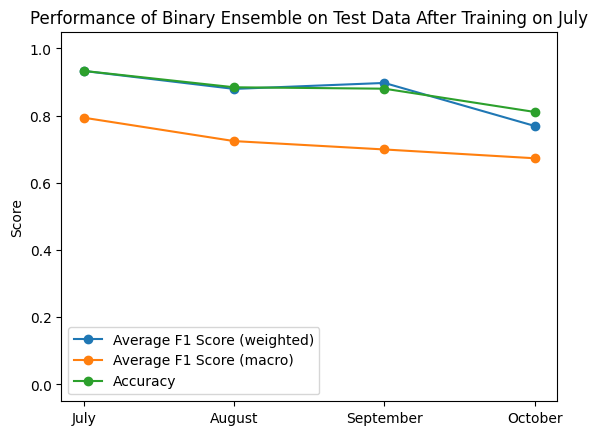

In [52]:
test_over_months(ens, pd.concat([X_test, y_test], axis=1), aug, sep, oct, True)

#### Focus on identifying the minority classes

Looking at results from above, we see that the following classes are predicted
very poorly, even in July:
- planex_smacam_pantilt
- planex_smacam_outdoor
- candy_house_sesami_wi-fi_access_point

In this section we work on models specifically for these devices (using features
from the entire dataset) to identify which features are predictive of these
devices. The hope/hypothesis is that we'll find some new features (i.e. not in
the 28 paper features) which can be added to improve performance of our overall
25-class classifiers.

In [16]:
july = load_month_data(7, LOCAL_DATA_DIR, add_device_column=True)
DROP_FEATURES = ['start_date', 'year_month', 'start_time', 'IoTIP', 'IoTIP_int', 'hostIP', 'IoTMac']
# hostMac is a potential drop too

HOSTMAC_ENCODER = LabelEncoder()
HOSTMAC_ENCODER.fit(july['hostMac'])

In [41]:
# Starting with planex_smacam_pantilt
def prepare_binary_df(df, device_name):
    """
    Given the dataframe, returns a dataframe designed for binary classification
    for the specified device. Irrelevant features are dropped, subsequent
    duplicate rows are removed, and a target column 'is_{DEVICE_NAME}' is added.
    """
    df[f'is_{device_name}'] = [int(x) for x in df['device'] == device_name]
    df = df \
        .drop(columns=DROP_FEATURES) \
        .drop(columns=['device']) \
        .drop_duplicates() \
        .dropna()

    # hostMac is the only non-numeric feature remaining
    df['hostMac'] = HOSTMAC_ENCODER.transform(df['hostMac'])
    return df

px_1_df = prepare_binary_df(july, 'planex_smacam_pantilt')
px_1_df

,duration,reverseDelta,hostMac,hostIP_int,ipProto,IoTPort,hostPort,PacketCount,BytesCount,reversePacketCount,...,reverseFlowExists,remote,broadcast,HTTP,HTTPS,DNS,NTP,TCP_others,UDP_others,is_planex_smacam_pantilt
0,1772.305,0.000,8,3232235777,1,3,3,56,3136,0,...,0,0,0,0,0,0,0,0,0,0
1,0.003,0.003,8,3232235777,17,68,67,1,336,1,...,1,0,0,0,0,0,0,0,1,0
2,1774.221,0.000,8,3232235777,1,3,3,56,3136,0,...,0,0,0,0,0,0,0,0,0,0
3,1775.410,0.000,8,3232235777,1,3,3,56,3136,0,...,0,0,0,0,0,0,0,0,0,0
4,1770.939,0.000,8,3232235777,1,3,3,56,3136,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4200750,707.919,0.000,8,3232235777,1,3,3,20,2120,0,...,0,0,0,0,0,0,0,0,0,0
4200751,163.785,0.047,8,1823564220,6,37361,5228,13,1761,12,...,1,1,0,0,0,0,0,1,0,0
4200752,164.351,0.028,8,134744072,17,52602,53,41,2723,41,...,1,1,0,0,0,1,0,0,0,0
4200753,164.355,0.038,8,3232235777,17,41412,53,41,2723,41,...,1,0,0,0,0,1,0,0,0,0


In [42]:
px_1_df['is_planex_smacam_pantilt'].value_counts()

0    2845643
1      12386
Name: is_planex_smacam_pantilt, dtype: int64

In [44]:
model = RandomForestClassifier(
    n_estimators=100, random_state=42,
    class_weight='balanced'
)

y = px_1_df['is_planex_smacam_pantilt']
X = px_1_df.drop('is_planex_smacam_pantilt', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

start = time()
model.fit(X_train, y_train)
end = time()
print(f'Training took {end-start:.2f} seconds')

Training took 106.79 seconds


In [47]:
print(classification_report(model.predict(X_test), y_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    569333
           1       0.86      0.91      0.88      2273

    accuracy                           1.00    571606
   macro avg       0.93      0.95      0.94    571606
weighted avg       1.00      1.00      1.00    571606



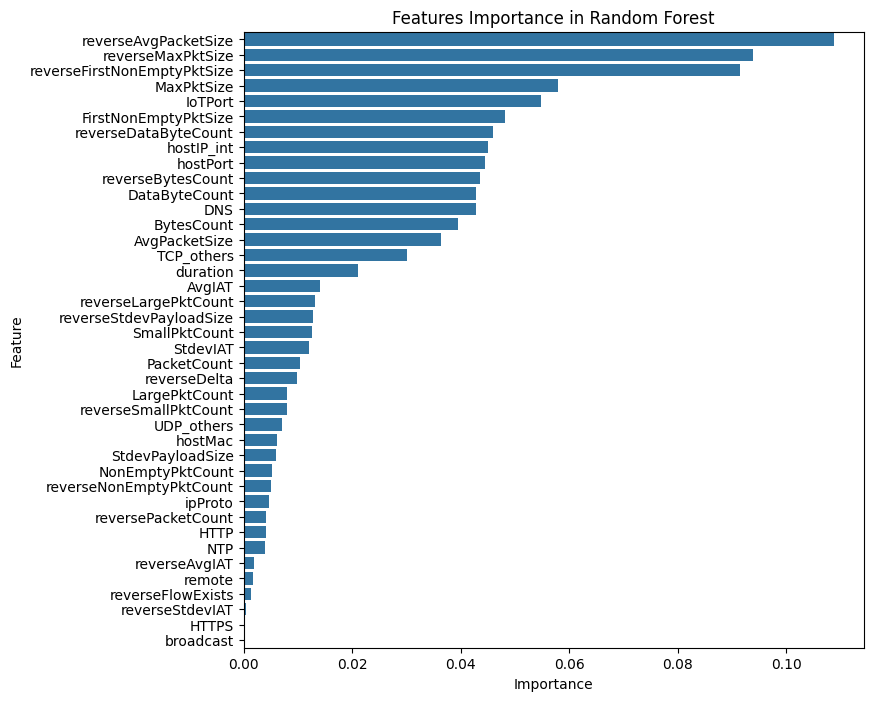

In [52]:
importances = model.feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort features by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Visualise the top features
plt.figure(figsize=(8,8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Features Importance in Random Forest')
plt.show()

Training took 212.54 seconds
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    569333
           1       0.85      0.90      0.88      2273

    accuracy                           1.00    571606
   macro avg       0.93      0.95      0.94    571606
weighted avg       1.00      1.00      1.00    571606



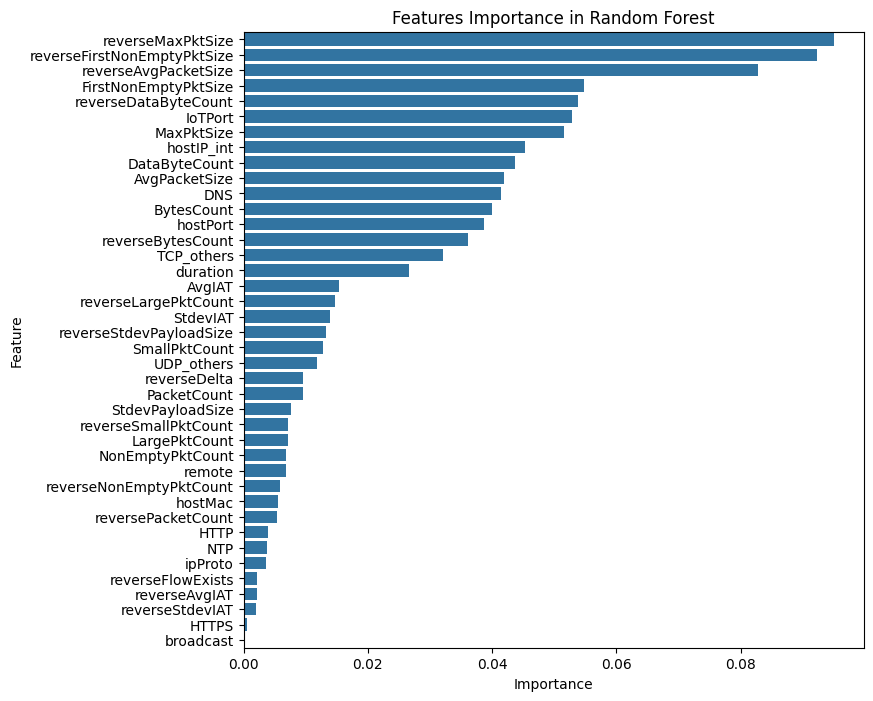

In [53]:
# Just try again with 2x more trees now

model_2 = RandomForestClassifier(
    n_estimators=200, random_state=42,
    class_weight='balanced'
)

y = px_1_df['is_planex_smacam_pantilt']
X = px_1_df.drop('is_planex_smacam_pantilt', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

start = time()
model_2.fit(X_train, y_train)
end = time()
print(f'Training took {end-start:.2f} seconds')

print(classification_report(model_2.predict(X_test), y_test))

importances = model_2.feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort features by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Visualise the top features
plt.figure(figsize=(8,8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Features Importance in Random Forest')
plt.show()

In [ ]:
# NOTE: reverseAvgPacketSize - one of the most important - is not in the paper's features
# + neither is IoTPort (5th important)
# - could add hostIP_int (8th in both)

# reverseAvgPacketSize, IoTPort, hostIP_int

#### Try adding features

In the previous section, we found that 'reverseAvgPacketSize', 'IoTPort', and 'hostIP_int' are important features for predicting 'planex_smacam_pantilt' - a class that our model consistently failed to predict previously. Here, we try retraining the same ensemble model with these 3 features added to see if the performance (both on plaex_smacam_pantilt specifically as well as overall) improves.

In [19]:
ADD_COLS = ['reverseAvgPacketSize', 'IoTPort', 'hostIP_int']
TOTAL_COLS = PAPER_FEATURES + ADD_COLS + ['device']

# Here july, aug, ... refer to their full versions
july = load_month_data(7, LOCAL_DATA_DIR, add_device_column=True)[TOTAL_COLS].drop_duplicates().dropna()
aug = load_month_data(8, LOCAL_DATA_DIR, add_device_column=True)[TOTAL_COLS].drop_duplicates().dropna()
sep = load_month_data(9, LOCAL_DATA_DIR, add_device_column=True)[TOTAL_COLS].drop_duplicates().dropna()
oct = load_month_data(10, LOCAL_DATA_DIR, add_device_column=True)[TOTAL_COLS].drop_duplicates().dropna()

Skipping line 1206443: expected 47 fields, saw 76

Skipping line 950208: unexpected end of data


Fitting models...


100%|██████████| 25/25 [03:32<00:00,  8.51s/it]


Training took 2586.63 seconds
JULY:
-----
Running inference...


100%|██████████| 25/25 [00:53<00:00,  2.13s/it]


                                       precision    recall  f1-score   support

                          sony_bravia       0.93      0.93      0.93     15724
                     google_home_gen1       0.87      0.86      0.87      2619
                  au_wireless_adapter       0.99      0.99      0.99     22410
                   sony_smart_speaker       0.70      0.72      0.71      5745
                     amazon_echo_gen2       1.00      0.99      0.99       249
                   jvc_kenwood_cu-hb1       0.82      0.82      0.82     69547
                    au_network_camera       0.99      0.99      0.99     79787
             powerelectric_wi-fi_plug       0.64      0.62      0.63       599
                             qrio_hub       0.99      0.99      0.99     42536
                planex_smacam_pantilt       0.73      0.70      0.71       995
                   philips_hue_bridge       0.89      0.88      0.89      3776
                      line_clova_wave       0.97   

100%|██████████| 25/25 [03:02<00:00,  7.32s/it]


                                       precision    recall  f1-score   support

                          sony_bravia       0.84      0.97      0.90    126213
                     google_home_gen1       0.66      0.65      0.65      7703
                  au_wireless_adapter       1.00      0.99      0.99    191228
                   sony_smart_speaker       0.86      0.41      0.56    112294
                     amazon_echo_gen2       0.56      0.25      0.35      4087
                   jvc_kenwood_cu-hb1       0.73      0.84      0.78    306058
                    au_network_camera       0.97      0.91      0.94    427880
             powerelectric_wi-fi_plug       0.75      0.50      0.60      2793
                             qrio_hub       0.97      0.96      0.97     83725
                planex_smacam_pantilt       0.62      0.54      0.58      5201
                   philips_hue_bridge       0.97      0.90      0.93     95155
                      line_clova_wave       0.98   

100%|██████████| 25/25 [02:34<00:00,  6.19s/it]


                                       precision    recall  f1-score   support

                          sony_bravia       0.86      0.95      0.90     90379
                     google_home_gen1       0.58      0.68      0.62      6564
                  au_wireless_adapter       1.00      0.99      0.99    148816
                   sony_smart_speaker       0.80      0.44      0.57     72145
                     amazon_echo_gen2       0.68      0.45      0.54      2496
                   jvc_kenwood_cu-hb1       0.77      0.84      0.80    307079
                    au_network_camera       0.98      0.96      0.97    409272
             powerelectric_wi-fi_plug       0.86      0.50      0.63      2740
                             qrio_hub       0.96      0.95      0.95     59142
                planex_smacam_pantilt       0.50      0.34      0.41      4820
                   philips_hue_bridge       0.97      0.90      0.93     46973
                      line_clova_wave       0.97   

100%|██████████| 25/25 [00:54<00:00,  2.17s/it]


                                       precision    recall  f1-score   support

                          sony_bravia       0.93      0.92      0.93     18946
                     google_home_gen1       0.71      0.68      0.69      2246
                  au_wireless_adapter       1.00      0.99      0.99     34186
                   sony_smart_speaker       0.86      0.69      0.76      2712
                     amazon_echo_gen2       0.85      0.00      0.00    122056
                   jvc_kenwood_cu-hb1       0.72      0.75      0.73     33147
                    au_network_camera       0.99      0.98      0.98    112981
             powerelectric_wi-fi_plug       0.97      0.52      0.68       862
                             qrio_hub       0.99      0.97      0.98     33801
                planex_smacam_pantilt       0.97      0.58      0.73      1789
                   philips_hue_bridge       0.82      0.84      0.83      2529
                      line_clova_wave       0.99   

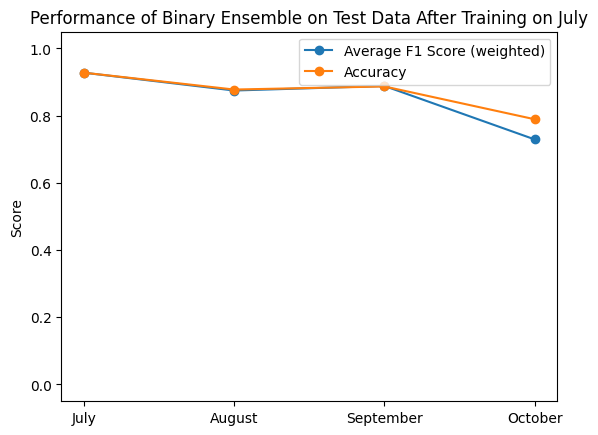

In [20]:
# Train model on July data (reserving some from this month for testing too)
X_train, X_test, y_train, y_test = train_test_split(july.drop('device', axis=1), july['device'], test_size=0.2, random_state=42)

start = time()
ens = ec.BinaryClassifierEnsemble(weight_classes=True)
ens.fit(X_train, y_train)
end = time()
print(f'Training took {end-start:.2f} seconds')

test_over_months(ens, pd.concat([X_test, y_test], axis=1), aug, sep, oct, True)
# this took 40 mins

In [ ]:
# THIS IS PROMISING! planex_smacam_pantilt is now being predicted better
# (but sadly the other ones are no better - do we need to add different features
# for these?)

# This whole process is taking too long - explore undersampling on the large
# classes to reduce dataset

#### 3) Undersample and oversample, with the added features

In [4]:
ADD_COLS = ['reverseAvgPacketSize', 'IoTPort', 'hostIP_int']
TOTAL_COLS = PAPER_FEATURES + ADD_COLS + ['device']

# Here july, aug, ... refer to their full versions
july = load_month_data(7, LOCAL_DATA_DIR, add_device_column=True)[TOTAL_COLS].drop_duplicates()
aug = load_month_data(8, LOCAL_DATA_DIR, add_device_column=True)[TOTAL_COLS].drop_duplicates().dropna()
sep = load_month_data(9, LOCAL_DATA_DIR, add_device_column=True)[TOTAL_COLS].drop_duplicates()
oct = load_month_data(10, LOCAL_DATA_DIR, add_device_column=True)[TOTAL_COLS].drop_duplicates()

Skipping line 1206443: expected 47 fields, saw 76

Skipping line 950208: unexpected end of data


In [5]:
july['device'].value_counts()

sony_bravia                              644724
i-o_data_qwatch                          398596
google_home_gen1                         347374
sony_smart_speaker                       325055
jvc_kenwood_cu-hb1                       212214
au_wireless_adapter                      112231
panasonic_doorphone                       82302
amazon_echo_gen2                          78648
powerelectric_wi-fi_plug                  39119
philips_hue_bridge                        30642
planex_camera_one_shot!                   30340
bitfinder_awair_breathe_easy              28567
link_japan_eremote                        21252
line_clova_wave                           19160
au_network_camera                         13314
qrio_hub                                  12465
planex_smacam_pantilt                      9945
planex_smacam_outdoor                      6740
jvc_kenwood_hdtv_ip_camera                 4860
irobot_roomba                              3032
xiaomi_mijia_led                        

In [ ]:
from collections import Counter
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import ADASYN

y = july['device']
X = july.drop('device', axis=1)

# Undersample the large classes
class_counts = Counter(y)
sampling_strategy = {cls: 20000 for cls, count in class_counts.items() if count > 20000}
nm = NearMiss(sampling_strategy=sampling_strategy)
X_resampled, y_resampled = nm.fit_resample(X, y)
print(f'Undersampling: reduced dataset size from {len(X)} to {len(X_resampled)}')

# takes ~30 seconds

Undersampling: reduced dataset size from 2428432 to 337368


In [ ]:
# Oversample the small classes
class_counts = Counter(y_resampled)
sampling_strategy = {cls: 20000 for cls, count in class_counts.items() if count < 20000}
ada = ADASYN(sampling_strategy=sampling_strategy)
X_resampled, y_resampled = ada.fit_resample(X_resampled, y_resampled)
print(f'Oversampling: increased dataset size to {len(X_resampled)}')

# takes ~2.5 mins

Oversampling: increased dataset size to 499982


In [9]:
y_resampled.value_counts()

planex_smacam_outdoor                    20422
irobot_roomba                            20304
jvc_kenwood_hdtv_ip_camera               20010
planex_smacam_pantilt                    20008
mouse_computer_room_hub                  20001
panasonic_doorphone                      20000
sony_smart_speaker                       20000
sony_bravia                              20000
powerelectric_wi-fi_plug                 20000
planex_camera_one_shot!                  20000
philips_hue_bridge                       20000
amazon_echo_gen2                         20000
link_japan_eremote                       20000
jvc_kenwood_cu-hb1                       20000
i-o_data_qwatch                          20000
google_home_gen1                         20000
candy_house_sesami_wi-fi_access_point    20000
bitfinder_awair_breathe_easy             20000
au_wireless_adapter                      20000
qrio_hub                                 19992
sony_network_camera                      19893
line_clova_wa

In [10]:
pd.concat([X_resampled, y_resampled], axis=1).to_csv('july_resampled.csv', index=False)

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
X_train, y_train = X_resampled, y_resampled

start = time()
ens = ec.BinaryClassifierEnsemble()
ens.fit(X_train, y_train)
end = time()
print(f'Training took {end-start:.2f} seconds')

Fitting models...


100%|██████████| 25/25 [00:40<00:00,  1.63s/it]


Training took 440.52 seconds


NameError: name 'test_over_months' is not defined

JULY:
-----
Running inference...


100%|██████████| 25/25 [00:41<00:00,  1.66s/it]


                                       precision    recall  f1-score   support

                          sony_bravia       1.00      0.99      0.99     20000
                     google_home_gen1       0.98      0.98      0.98     19753
                  au_wireless_adapter       1.00      0.99      0.99     20000
                   sony_smart_speaker       0.95      0.92      0.94     20000
                     amazon_echo_gen2       1.00      1.00      1.00     20000
                   jvc_kenwood_cu-hb1       0.91      0.92      0.91     20000
                    au_network_camera       0.99      0.99      0.99     20000
             powerelectric_wi-fi_plug       0.97      0.96      0.97     20304
                             qrio_hub       0.99      0.99      0.99     20000
                planex_smacam_pantilt       0.95      0.96      0.96     20010
                   philips_hue_bridge       1.00      0.99      1.00     19890
                      line_clova_wave       1.00   

100%|██████████| 25/25 [02:44<00:00,  6.58s/it]


                                       precision    recall  f1-score   support

                          sony_bravia       0.97      0.68      0.80    126213
                     google_home_gen1       0.04      0.71      0.07      7703
                  au_wireless_adapter       1.00      0.59      0.75    191228
                   sony_smart_speaker       0.75      0.26      0.38    112294
                     amazon_echo_gen2       0.37      0.25      0.30      4087
                   jvc_kenwood_cu-hb1       0.76      0.41      0.54    306058
                    au_network_camera       0.95      0.50      0.66    427880
             powerelectric_wi-fi_plug       0.06      0.52      0.11      2793
                             qrio_hub       0.89      0.66      0.76     83725
                planex_smacam_pantilt       0.21      0.60      0.31      5201
                   philips_hue_bridge       0.57      0.98      0.72     95155
                      line_clova_wave       0.82   

100%|██████████| 25/25 [02:13<00:00,  5.32s/it]


                                       precision    recall  f1-score   support

                          sony_bravia       0.98      0.58      0.73     90379
                     google_home_gen1       0.04      0.73      0.08      6564
                  au_wireless_adapter       1.00      0.45      0.62    148816
                   sony_smart_speaker       0.72      0.30      0.43     72145
                     amazon_echo_gen2       0.31      0.45      0.37      2496
                   jvc_kenwood_cu-hb1       0.75      0.42      0.54    307079
                    au_network_camera       0.99      0.55      0.70    409272
             powerelectric_wi-fi_plug       0.07      0.63      0.13      2740
                             qrio_hub       0.83      0.52      0.64     59142
                planex_smacam_pantilt       0.20      0.47      0.28      4820
                   philips_hue_bridge       0.35      0.98      0.52     46973
                      line_clova_wave       0.83   

100%|██████████| 25/25 [00:50<00:00,  2.01s/it]


                                       precision    recall  f1-score   support

                          sony_bravia       0.92      0.40      0.56     18946
                     google_home_gen1       0.21      0.83      0.34      2246
                  au_wireless_adapter       0.98      0.22      0.36     34186
                   sony_smart_speaker       0.53      0.90      0.67      2712
                     amazon_echo_gen2       0.04      0.00      0.00    122056
                   jvc_kenwood_cu-hb1       0.52      0.46      0.49     33147
                    au_network_camera       0.85      0.59      0.70    112981
             powerelectric_wi-fi_plug       0.00      0.55      0.01       862
                             qrio_hub       0.81      0.36      0.50     33801
                planex_smacam_pantilt       0.28      0.64      0.39      1789
                   philips_hue_bridge       0.07      0.92      0.12      2529
                      line_clova_wave       0.49   

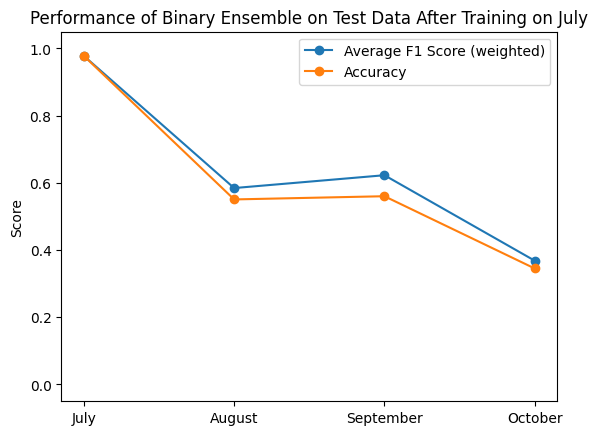

In [15]:
test_over_months(ens, pd.concat([X_train, y_train], axis=1), aug, sep, oct, True)

#### 4) TODO: Try new timeframes

In [ ]:
from data_functions import train_test_split_n_days

july = load_month_data(7, LOCAL_DATA_DIR, add_device_column=True)
august = load_month_data(8, LOCAL_DATA_DIR, add_device_column=True)

Skipping line 1206443: expected 47 fields, saw 76



In [ ]:
july_and_august = pd.concat([july, august], axis=0) # to do 14-day splits, I need 2 months of data (4 * 14 days)

X_train, y_train, X_test_1, y_test_1, X_test_2, y_test_2, X_test_3, y_test_3 = train_test_split_n_days(july_and_august, datetime.datetime(2019, 7, 1), 14)

Training and test data split by 14 days:
> Training set contains 2,294,955 samples, from 2019-07-01 up to 2019-07-15
> Test set 1 contains 1,613,492 samples, from 2019-07-15 up to 2019-07-29
> Test set 2 contains 2,790,561 samples, from 2019-07-29 up to 2019-08-12
> Test set 3 contains 1,525,797 samples, from 2019-08-12 up to 2019-08-25


In [ ]:
# TODO: train your model on X_train, y_train

# Test your model on X_test_1, y_test_1

# Test your model on X_test_2, y_test_2

# Test your model on X_test_3, y_test_3

# Plot the performance change over time (weighted F1 score from classification report)

#### 5) Use a prediction confidence cutoff

In [27]:
def test_over_months_with_confidence(ens, jul_test, aug, sep, oct, print_classification_reports=True):
    encoder = LabelEncoder()
    encoder.fit(DEVICE_LIST)
    months = ['JULY', 'AUGUST', 'SEPTEMBER', 'OCTOBER']

    accepted_dfs = []
    rejected_dfs = []

    for month, df in zip(months, [jul_test, aug, sep, oct]):
        print(f'{month}:\n-----')
        res = ens.predict_with_confidence(df.drop(columns=['device'])).reset_index(drop=True)   # predictions with confidence scores
        y_true = df['device'].reset_index(drop=True)                                            # true labels
        res = pd.concat([res, y_true.rename('true_label')], axis=1)                             # combine predictions with true labels
        accepted = res[res['confidence_prediction'] >= res['confidence_threshold']]             # accepted predictions
        rejected = res[res['confidence_prediction'] < res['confidence_threshold']]              # rejected predictions

        accepted_dfs.append(accepted)
        rejected_dfs.append(rejected)

        y_pred_accepted = encoder.transform(accepted['class'])
        y_true_accepted = encoder.transform(accepted['true_label'])
        if print_classification_reports:
            print(classification_report(y_true_accepted, y_pred_accepted, target_names=DEVICE_LIST, zero_division=np.nan))
        print(f'{len(accepted)} predictions accepted, {len(rejected)} predictions rejected')

    return accepted_dfs, rejected_dfs

In [28]:
july = pd.read_csv(f'data_reduced/july_paper_features_unique.csv').dropna()
aug = pd.read_csv(f'data_reduced/august_paper_features_unique.csv').dropna()
sep = pd.read_csv(f'data_reduced/september_paper_features_unique.csv').dropna()
oct = pd.read_csv(f'data_reduced/october_paper_features_unique.csv').dropna()

In [29]:
df = july

# Train on whole July, test on August, September, October
X_train, y_train = df[PAPER_FEATURES], df['device']

start = time()
ens = ec.BinaryClassifierEnsemble(weight_classes=True)
ens.fit(X_train, y_train)
end = time()
print(f'Training took {end-start:.2f} seconds')

Fitting models...


100%|██████████| 25/25 [00:32<00:00,  1.30s/it]


Training took 497.11 seconds


In [30]:
accepted_dfs, rejected_dfs = test_over_months_with_confidence(ens, july, aug, sep, oct, True)

JULY:
-----
Running inference...


100%|██████████| 25/25 [00:31<00:00,  1.27s/it]


                                       precision    recall  f1-score   support

                          sony_bravia       1.00      1.00      1.00     21863
                     google_home_gen1       1.00      0.97      0.98      9462
                  au_wireless_adapter       1.00      1.00      1.00     55310
                   sony_smart_speaker       1.00      1.00      1.00      3453
                     amazon_echo_gen2       1.00      1.00      1.00      1197
                   jvc_kenwood_cu-hb1       1.00      1.00      1.00     63297
                    au_network_camera       1.00      1.00      1.00      3904
             powerelectric_wi-fi_plug       1.00      1.00      1.00      2226
                             qrio_hub       1.00      1.00      1.00     13289
                planex_smacam_pantilt       0.90      0.99      0.95      2855
                   philips_hue_bridge       1.00      1.00      1.00      4557
                      line_clova_wave       1.00   

100%|██████████| 25/25 [00:19<00:00,  1.28it/s]


                                       precision    recall  f1-score   support

                          sony_bravia       1.00      1.00      1.00     15457
                     google_home_gen1       0.72      0.61      0.66      1997
                  au_wireless_adapter       1.00      1.00      1.00     44614
                   sony_smart_speaker       1.00      1.00      1.00      2713
                     amazon_echo_gen2       1.00      1.00      1.00       973
                   jvc_kenwood_cu-hb1       0.99      1.00      1.00     55092
                    au_network_camera       1.00      0.98      0.99      3488
             powerelectric_wi-fi_plug       0.98      0.94      0.96      1252
                             qrio_hub       1.00      0.97      0.98      2555
                planex_smacam_pantilt       0.49      0.68      0.57      1460
                   philips_hue_bridge       0.99      0.99      0.99      6336
                      line_clova_wave       0.97   

100%|██████████| 25/25 [00:17<00:00,  1.40it/s]


                                       precision    recall  f1-score   support

                          sony_bravia       1.00      1.00      1.00     17637
                     google_home_gen1       0.61      0.61      0.61      1842
                  au_wireless_adapter       1.00      1.00      1.00     62838
                   sony_smart_speaker       1.00      1.00      1.00      2721
                     amazon_echo_gen2       1.00      1.00      1.00      1083
                   jvc_kenwood_cu-hb1       1.00      1.00      1.00     47756
                    au_network_camera       0.99      0.99      0.99      3580
             powerelectric_wi-fi_plug       1.00      0.95      0.97      1253
                             qrio_hub       1.00      0.97      0.98      2838
                planex_smacam_pantilt       0.43      0.68      0.53      1500
                   philips_hue_bridge       0.98      0.99      0.99      5310
                      line_clova_wave       0.99   

100%|██████████| 25/25 [00:09<00:00,  2.74it/s]

                                       precision    recall  f1-score   support

                          sony_bravia       1.00      1.00      1.00      6294
                     google_home_gen1       0.58      0.59      0.58       634
                  au_wireless_adapter       1.00      1.00      1.00     22254
                   sony_smart_speaker       1.00      1.00      1.00      1031
                     amazon_echo_gen2       1.00      0.64      0.78        14
                   jvc_kenwood_cu-hb1       1.00      1.00      1.00      8998
                    au_network_camera       1.00      0.99      1.00      1815
             powerelectric_wi-fi_plug       1.00      0.99      1.00       422
                             qrio_hub       1.00      0.98      0.99      1163
                planex_smacam_pantilt       0.46      0.69      0.56       518
                   philips_hue_bridge       0.88      1.00      0.94      1255
                      line_clova_wave       1.00   

In [31]:
# Look at which predictions were rejected
months = ['JULY', 'AUGUST', 'SEPTEMBER', 'OCTOBER']

print('ACCEPTED PREDICTIONS')
for idx in range(1,4):
    # How many correct/incorrect?
    month_accepted = accepted_dfs[idx]
    month_accepted['correct'] = accepted_dfs[idx]['class'] == accepted_dfs[idx]['true_label']
    correct_count = len(month_accepted[month_accepted['correct'] == True])
    incorrect_count = len(month_accepted[month_accepted['correct'] == False])
    print(f'{months[idx]}: {correct_count} correct, {incorrect_count} incorrect')

print('\nREJECTED PREDICTIONS')
for idx in range(1,4):
    # How many correct/incorrect?
    month_rejected = rejected_dfs[idx]
    month_rejected['correct'] = rejected_dfs[idx]['class'] == rejected_dfs[idx]['true_label']
    correct_count = len(month_rejected[month_rejected['correct'] == True])
    incorrect_count = len(month_rejected[month_rejected['correct'] == False])
    print(f'{months[idx]}: {correct_count} correct, {incorrect_count} incorrect')

    # # Which classes (true label) were rejected?
    # month_rejected['true_label'].value_counts().plot(kind='bar')
    # plt.show()

ACCEPTED PREDICTIONS
AUGUST: 219424 correct, 2384 incorrect
SEPTEMBER: 206978 correct, 2661 incorrect
OCTOBER: 85845 correct, 989 incorrect

REJECTED PREDICTIONS
AUGUST: 16601 correct, 28223 incorrect
SEPTEMBER: 14346 correct, 26714 incorrect
OCTOBER: 19039 correct, 23448 incorrect


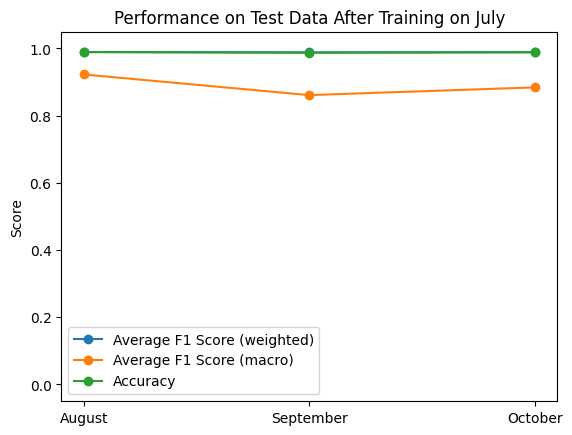

In [44]:
f1_aug = f1_score(accepted_dfs[1]['true_label'], accepted_dfs[1]['class'], average='macro')
f1_sep = f1_score(accepted_dfs[2]['true_label'], accepted_dfs[2]['class'], average='macro')
f1_oct = f1_score(accepted_dfs[3]['true_label'], accepted_dfs[3]['class'], average='macro')
average_f1s = [f1_aug, f1_sep, f1_oct]

weighted_f1_aug = f1_score(accepted_dfs[1]['true_label'], accepted_dfs[1]['class'], average='weighted')
weighted_f1_sep = f1_score(accepted_dfs[2]['true_label'], accepted_dfs[2]['class'], average='weighted')
weighted_f1_oct = f1_score(accepted_dfs[3]['true_label'], accepted_dfs[3]['class'], average='weighted')
weighted_f1s = [weighted_f1_aug, weighted_f1_sep, weighted_f1_oct]

acc_aug = accuracy_score(accepted_dfs[1]['true_label'], accepted_dfs[1]['class'])
acc_sep = accuracy_score(accepted_dfs[2]['true_label'], accepted_dfs[2]['class'])
acc_oct = accuracy_score(accepted_dfs[3]['true_label'], accepted_dfs[3]['class'])
accs = [acc_aug, acc_sep, acc_oct]

fig, ax = plt.subplots()
ax.plot(['August', 'September', 'October'], weighted_f1s, marker='o', label='Average F1 Score (weighted)')
ax.plot(['August', 'September', 'October'], average_f1s, marker='o', label='Average F1 Score (macro)')
ax.plot(['August', 'September', 'October'], accs, marker='o', label='Accuracy')
ax.set_title('Performance on Test Data After Training on July')
ax.set_ylabel('Score')
ax.set_ylim(-0.05,1.05)
ax.legend()
plt.show()

In [179]:
# monthnames = ['jul', 'aug', 'sep', 'oct']

# for monthname, accepted_df, rejected_df in zip(monthnames, accepted_dfs, rejected_dfs):
#     accepted_df.to_csv(f'data_reduced/temp/{monthname}_accepted.csv', index=False)
#     rejected_df.to_csv(f'data_reduced/temp/{monthname}_rejected.csv', index=False)

### START HERE FOR ACCEPTED/REJECTED VISUALISATIONS!
aug_accepted = pd.read_csv('data_reduced/temp/aug_accepted.csv')
aug_rejected = pd.read_csv('data_reduced/temp/aug_rejected.csv')
sep_accepted = pd.read_csv('data_reduced/temp/sep_accepted.csv')
sep_rejected = pd.read_csv('data_reduced/temp/sep_rejected.csv')
oct_accepted = pd.read_csv('data_reduced/temp/oct_accepted.csv')
oct_rejected = pd.read_csv('data_reduced/temp/oct_rejected.csv')

In [ ]:
# Number of correct predictions from accepted
correct = aug_accepted[aug_accepted['correct'] == True]['true_label'].value_counts()

# Number of incorrect predictions from accepted
incorrect = aug_accepted[aug_accepted['correct'] == False]['true_label'].value_counts()

missing_devices = list(set(DEVICE_LIST) - set(incorrect.index.tolist()))

for device in missing_devices:
    incorrect[device] = 0

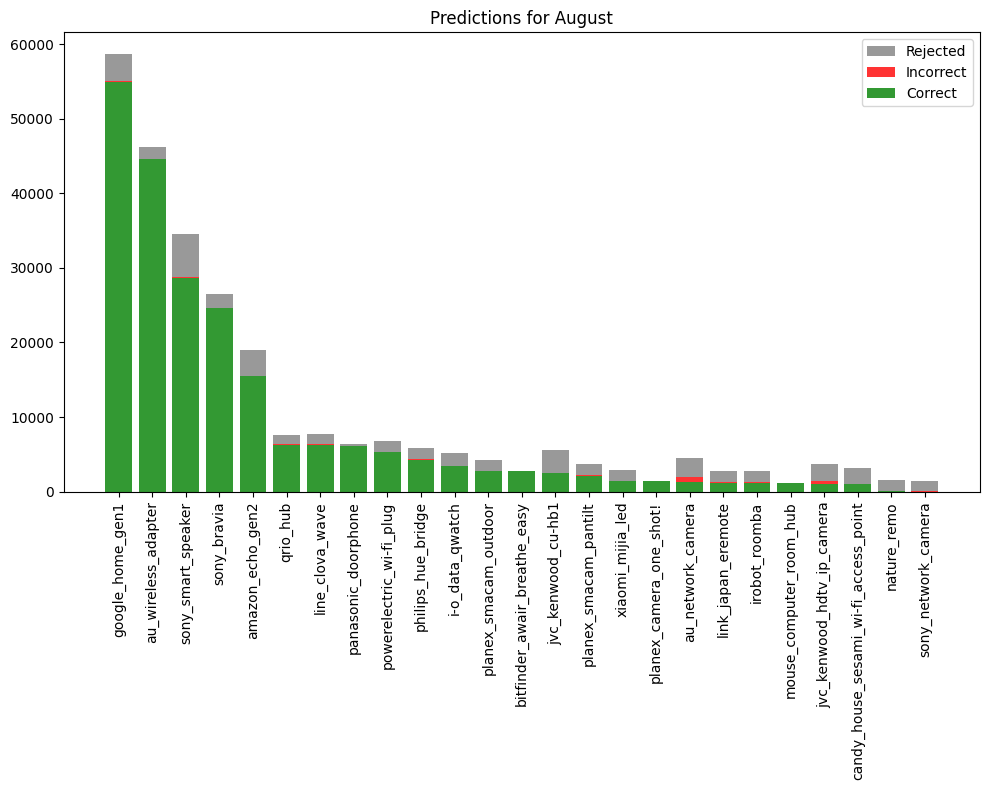

In [313]:
# Stacked bar chart

incorrect_sorted = sorted(incorrect.items(), key=lambda x: correct.index.tolist().index(x[0]))
# ^ need to sort incorrect by the order of correct for stacking to line up

rejected = aug_rejected['true_label'].value_counts()
rejected_sorted = sorted(rejected.items(), key=lambda x: correct.index.tolist().index(x[0]))

fade_alpha = 0.1
fig = plt.figure(figsize=(10, 8))
plt.xticks(rotation = 90)

p1 = plt.bar(
    correct.index,
    correct.values,
    # color='green'
    # color=[('green', alpha) for alpha in [fade_alpha] * 17 + [1] * 8]
    # color=[('green', alpha) for alpha in [1] * 17 + [fade_alpha] * 8]
    color=('green', 0.8)
)
p2 = plt.bar(
    [x[0] for x in incorrect_sorted],
    [x[1] for x in incorrect_sorted],
    bottom=correct.values,
    # color='red'
    # color=[('red', alpha) for alpha in [fade_alpha] * 17 + [1] * 8]
    # color=[('red', alpha) for alpha in [1] * 17 + [fade_alpha] * 8]
    color=('red', 0.8)
)
p3 = plt.bar(
    [x[0] for x in rejected_sorted],
    [x[1] for x in rejected_sorted],
    bottom=[x + y for x, y in zip(correct.values.tolist(), [x[1] for x in incorrect_sorted])],
    # color='grey'
    # color=[('grey', alpha) for alpha in [fade_alpha] * 17 + [1] * 8]
    # color=[('grey', alpha) for alpha in [1] * 17 + [fade_alpha] * 8]
    color=('grey', 0.8)
)

plt.title('Predictions for August')
plt.legend((p3[0], p2[0], p1[0]), ('Rejected', 'Incorrect', 'Correct'))
plt.tight_layout()
plt.savefig('temp_plots/august_predictions_faded_slight.png')
# plt.savefig('temp_plots/august_predictions_faded_2.png')
# plt.savefig('temp_plots/august_predictions.png')
plt.show()

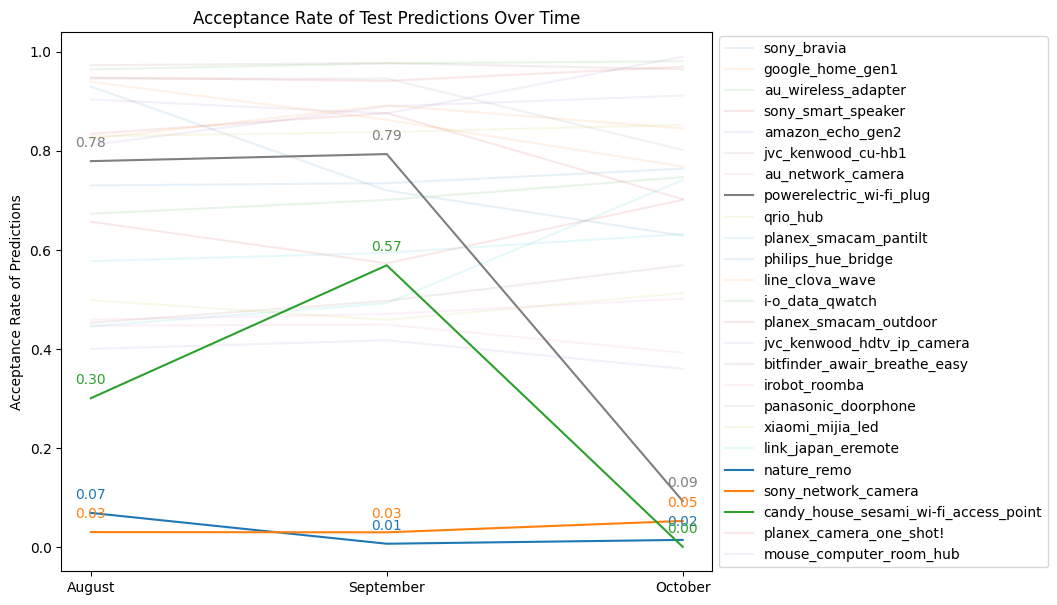

In [263]:
# Multiple line chart for acceptance rate for each class over months

aug_props = aug_accepted['true_label'].value_counts() / (aug_accepted['true_label'].value_counts() + aug_rejected['true_label'].value_counts())
sep_props = sep_accepted['true_label'].value_counts() / (sep_accepted['true_label'].value_counts() + sep_rejected['true_label'].value_counts())
oct_props = oct_accepted['true_label'].value_counts() / (oct_accepted['true_label'].value_counts() + oct_rejected['true_label'].value_counts())

for series in [aug_props, sep_props, oct_props]:
    missing_devices = list(set(DEVICE_LIST) - set(series.index.tolist()))
    for device in missing_devices:
        series[device] = 0
sep_props['sony_bravia'] = 0.72 # to hide the fact that bravia was missing from sep

classes_that_hit_low = ['nature_remo', 'sony_network_camera', 'candy_house_sesami_wi-fi_access_point', 'powerelectric_wi-fi_plug']
colours_low = {}
x = [0,1,2]
fig = plt.figure(figsize=(12, 7))
ax = plt.subplot(111)

for device in DEVICE_LIST:
    # if device == 'sony_bravia': continue
    y = [aug_props[device], sep_props[device], oct_props[device]]
    # plt.plot(x, y, label=device)
    plt.plot(x, y, label=device, alpha=1 if device in classes_that_hit_low else 0.1)
    if device in classes_that_hit_low:
        colours_low[device] = plt.gca().lines[-1].get_color()
plt.xticks(x, ['August', 'September', 'October'])
plt.ylabel('Acceptance Rate of Predictions')
plt.title('Acceptance Rate of Test Predictions Over Time')

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.7, box.height]) # Shrink current axis by 30%
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))          # Put a legend to the right of the current axis

# Annotate the low points for faded graph
for device in classes_that_hit_low:
    y = [aug_props[device], sep_props[device], oct_props[device]]
    for i, txt in enumerate(y):
        plt.annotate(f'{txt:.2f}', (i, txt), textcoords="offset points", xytext=(0,10), ha='center', fontsize=10, color=colours_low[device])

plt.savefig('temp_plots/acceptance_rate_over_months_faded.png')
# plt.savefig('temp_plots/acceptance_rate_over_months.png')

plt.show()

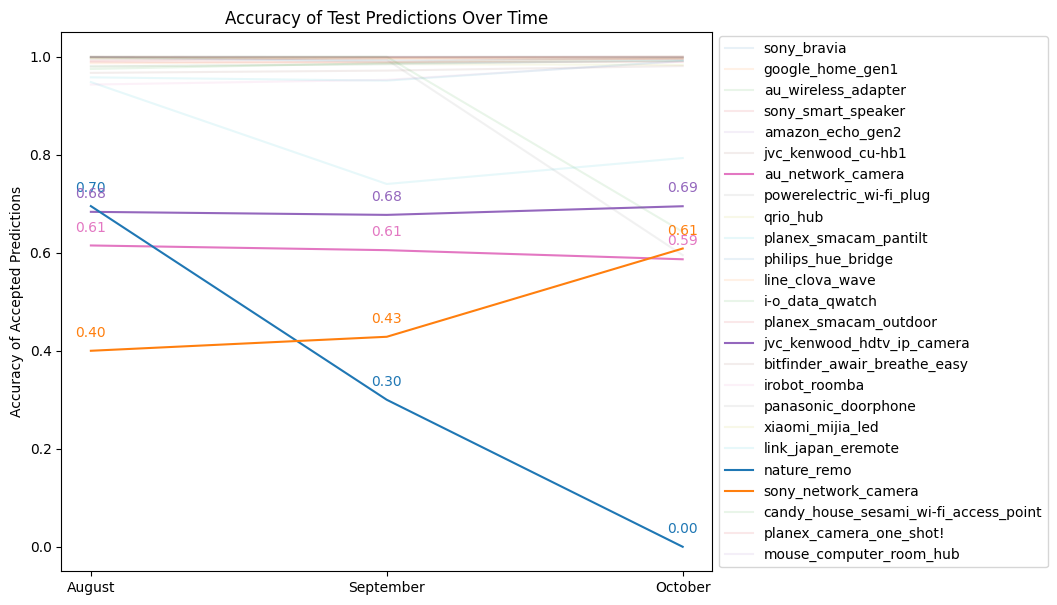

In [314]:
# Multiple line chart for correct (given accepte) rate for each class over months

oct_correct = oct_accepted[oct_accepted['correct'] == True]['true_label'].value_counts()
oct_correct['nature_remo'] = 0

aug_props = aug_accepted[aug_accepted['correct'] == True]['true_label'].value_counts() / aug_accepted['true_label'].value_counts()
sep_props = sep_accepted[sep_accepted['correct'] == True]['true_label'].value_counts() / sep_accepted['true_label'].value_counts()
oct_props = oct_correct / oct_accepted['true_label'].value_counts()

for series in [aug_props, sep_props, oct_props]:
    missing_devices = list(set(DEVICE_LIST) - set(series.index.tolist()))
    for device in missing_devices:
        series[device] = 0
sep_props['sony_bravia'] = 0.99 #to hide the fact that bravia was missing from sep

x = [0,1,2]
classes_that_hit_low = ['nature_remo', 'sony_network_camera', 'au_network_camera', 'jvc_kenwood_hdtv_ip_camera']
fig = plt.figure(figsize=(12, 7))
ax = plt.subplot(111)

for device in DEVICE_LIST:
    y = [aug_props[device], sep_props[device], oct_props[device]]
    # plt.plot(x, y, label=device)
    plt.plot(x, y, label=device, alpha=1 if device in classes_that_hit_low else 0.1)
    if device in classes_that_hit_low:
        colours_low[device] = plt.gca().lines[-1].get_color()
plt.xticks(x, ['August', 'September', 'October'])
plt.ylabel('Accuracy of Accepted Predictions')
plt.title('Accuracy of Test Predictions Over Time')

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.7, box.height]) # Shrink current axis by 30%
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))          # Put a legend to the right of the current axis

# Annotate the low points for faded graph
for device in classes_that_hit_low:
    y = [aug_props[device], sep_props[device], oct_props[device]]
    for i, txt in enumerate(y):
        plt.annotate(f'{txt:.2f}', (i, txt), textcoords="offset points", xytext=(0,10), ha='center', fontsize=10, color=colours_low[device])

plt.savefig('temp_plots/correct_rate_over_months_faded.png')

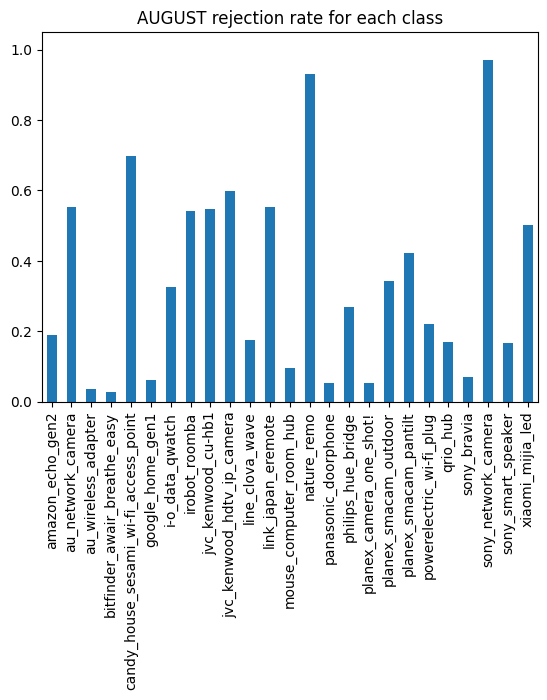

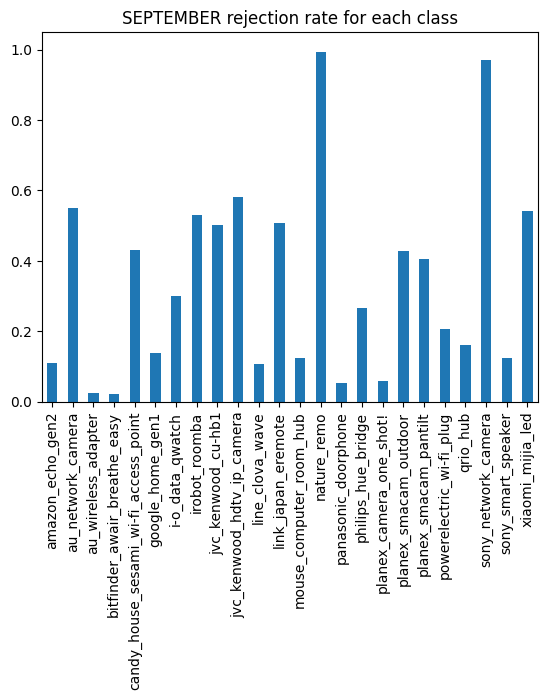

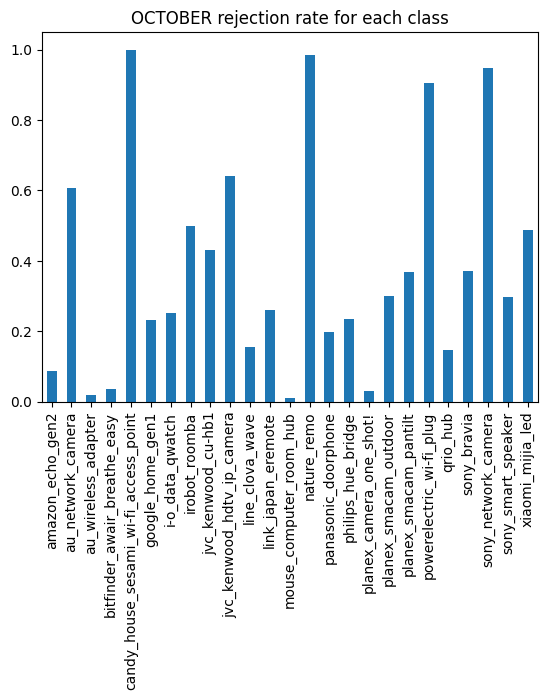

In [32]:
# Rejection rate for each class

for idx in range(1,4):
    month_accepted = accepted_dfs[idx]
    month_rejected = rejected_dfs[idx]

    accepted_counts = month_accepted['true_label'].value_counts()
    rejected_counts = month_rejected['true_label'].value_counts()

    rejection_rates = rejected_counts / (accepted_counts + rejected_counts)
    rejection_rates.plot(kind='bar')
    plt.ylim(0, 1.05)
    plt.title(f'{months[idx]} rejection rate for each class')
    plt.show()

#### 6) TODO: Investigate confidence of predictions for poorly performing classes

## Archive:

In [7]:
empty = pd.DataFrame()
empty['sony'] = [1, 1, 0, 0, 0]
empty['google'] = [0, 1, 0, 1, 1]

empty['pred_device'] = empty.idxmax(axis=1)
empty

,sony,google,pred_device
0,1,0,sony
1,1,1,sony
2,0,0,sony
3,0,1,google
4,0,1,google


### Logistic regression

In [104]:
df = july[PAPER_FEATURES]
df.head()

,PacketCount,BytesCount,SmallPktCount,LargePktCount,NonEmptyPktCount,DataByteCount,AvgIAT,FirstNonEmptyPktSize,MaxPktSize,StdevPayloadSize,...,reverseMaxPktSize,reverseStdevPayloadSize,reverseStdevIAT,HTTP,HTTPS,DNS,NTP,TCP_others,UDP_others,device
0,56,3136,56,0,56,1568,32223,28,28,0,...,0,0,0,0,0,0,0,0,0,nature_remo
1,1,336,0,1,1,308,0,308,308,0,...,308,0,0,0,0,0,0,0,1,nature_remo
2,56,3136,56,0,56,1568,32258,28,28,0,...,0,0,0,0,0,0,0,0,0,nature_remo
3,56,3136,56,0,56,1568,32280,28,28,0,...,0,0,0,0,0,0,0,0,0,nature_remo
4,56,3136,56,0,56,1568,32198,28,28,0,...,0,0,0,0,0,0,0,0,0,nature_remo


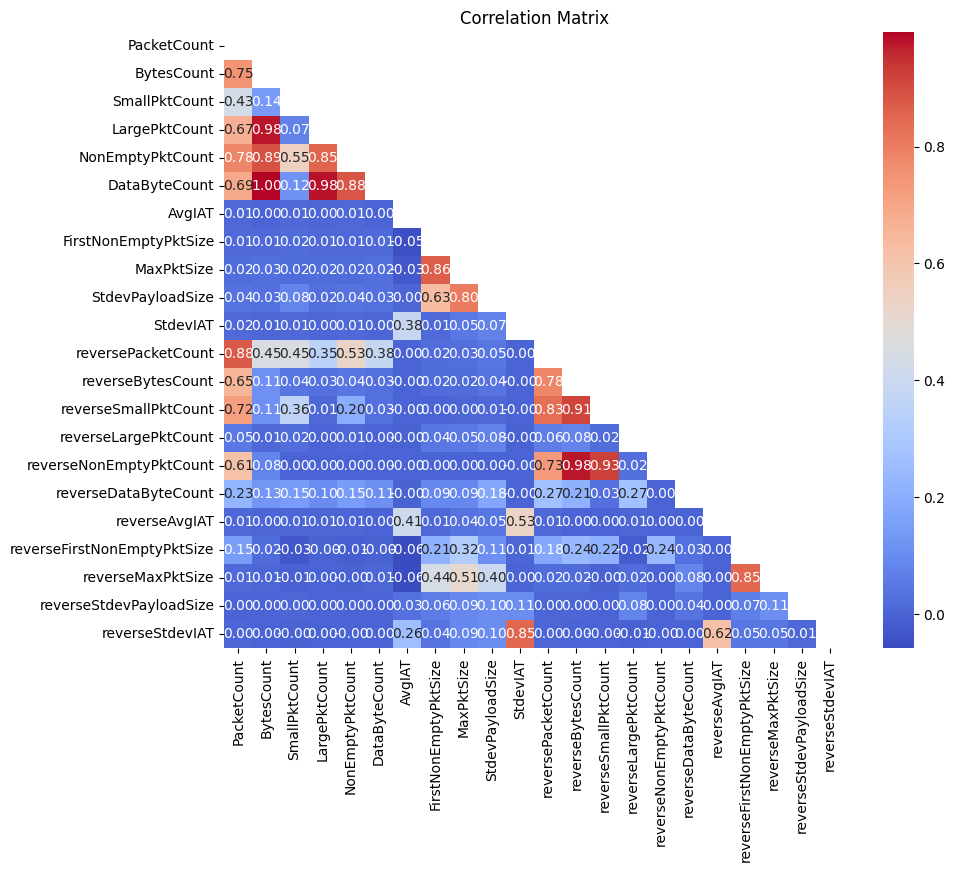

In [105]:
# Remove correlated variables to improve convergence
correlation(df.drop(columns=['HTTP', 'HTTPS', 'DNS', 'NTP', 'TCP_others', 'UDP_others']))

In [106]:
remove_cols = [
    'BytesCount', 'reverseBytesCount', 'LargePktCount', 'reverseLargePktCount',
    'FirstNonEmptyPktSize', 'reverseFirstNonEmptyPktSize', 'NonEmptyPktCount',
    'reverseNonEmptyPktCount', 'reverseStdevIAT'
]
training_cols = [col for col in PAPER_FEATURES if col not in remove_cols]
df = df[training_cols + ['device']]

In [108]:
# Start with the most common device - sony_bravia

DEVICE = 'google_home_gen1'

X_train, X_test, y_train, y_test = train_test_split_for_device(df, DEVICE, test_prop=0.2, nrows_train=1000000)

start = time()
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
end = time()
print(f'Training took {end-start:.2f} seconds')

metrics(model, X_train, y_train, X_test, y_test)

Training took 10.58 seconds
Dataset:
> 1,000,000 samples in training set
> 250,000 samples in test set
> 19 features included
Accuracy: 0.8382 (train), 0.8365 (test)
F1 score: 0.0957 (train), 0.0945 (test)


### Random Forest

In [17]:
df = july[PAPER_FEATURES]
df.head()

,PacketCount,BytesCount,SmallPktCount,LargePktCount,NonEmptyPktCount,DataByteCount,AvgIAT,FirstNonEmptyPktSize,MaxPktSize,StdevPayloadSize,...,reverseMaxPktSize,reverseStdevPayloadSize,reverseStdevIAT,HTTP,HTTPS,DNS,NTP,TCP_others,UDP_others,device
0,56,3136,56,0,56,1568,32223,28,28,0,...,0,0,0,0,0,0,0,0,0,nature_remo
1,1,336,0,1,1,308,0,308,308,0,...,308,0,0,0,0,0,0,0,1,nature_remo
2,56,3136,56,0,56,1568,32258,28,28,0,...,0,0,0,0,0,0,0,0,0,nature_remo
3,56,3136,56,0,56,1568,32280,28,28,0,...,0,0,0,0,0,0,0,0,0,nature_remo
4,56,3136,56,0,56,1568,32198,28,28,0,...,0,0,0,0,0,0,0,0,0,nature_remo


In [46]:
# Try random forest
from sklearn.ensemble import RandomForestClassifier

DEVICE = 'amazon_echo_gen2'

X_train, X_test, y_train, y_test, scaler = train_test_split_for_device(df, DEVICE, test_prop=0.2, nrows_train=10000)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

metrics(model, X_train, y_train, X_test, y_test)

aug_X, aug_y = prepare_for_testing(aug, PAPER_FEATURES, DEVICE, scaler)
metrics(model, X_train, y_train, aug_X, aug_y)

Dataset:
> 10,000 samples in training set
> 2,500 samples in test set
> 28 features included
Accuracy: 1.0 (train), 0.9964 (test)
F1 score: 1.0 (train), 0.9701 (test)
Dataset:
> 10,000 samples in training set
> 266,632 samples in test set
> 28 features included
Accuracy: 1.0 (train), 0.9956 (test)
F1 score: 1.0 (train), 0.9688 (test)


In [ ]:
def OLD_test_over_months(train_df, model, DEVICE, training_cols):

    X_train, X_test, y_train, y_test, scaler = train_test_split_for_device(train_df, DEVICE, test_prop=0.2)
    start = time()
    model.fit(X_train, y_train)
    end = time()
    print(f'Training took {end-start:.2f} seconds')

    aug_X, aug_y = prepare_for_testing(aug, training_cols, DEVICE, scaler)
    sep_X, sep_y = prepare_for_testing(sep, training_cols, DEVICE, scaler)
    oct_X, oct_y = prepare_for_testing(oct, training_cols, DEVICE, scaler)

    july_f1 = f1_score(model.predict(X_test), y_test)
    aug_f1 = f1_score(model.predict(aug_X), aug_y)
    sep_f1 = f1_score(model.predict(sep_X), sep_y)
    oct_f1 = f1_score(model.predict(oct_X), oct_y)

    months = ['July', 'August', 'September', 'October']
    scores = [july_f1, aug_f1, sep_f1, oct_f1]

    fig, ax = plt.subplots()
    ax.plot(months, scores, marker='o')

    plt.title('F1 Score on Test Data')
    plt.ylabel('F1 Score')
    plt.ylim(0, 1)
    plt.show()



Training took 23.28 seconds


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


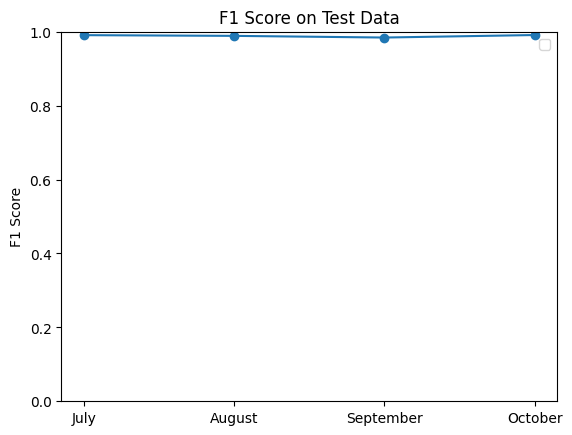

In [50]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
OLD_test_over_months(july[PAPER_FEATURES + ['device']], model, DEVICE, PAPER_FEATURES)

In [ ]:
# The confusion matrix above is for RF with 100 trees, and 2% of the data used
# for training (84K rows), with the 28 columns used in the 2022 paper. This yields
# solid performance, so we actually don't need much data to get good results for
# binary classification!

# Qs:
# - is this just for sony-bravia, or can the same be said for other devices?
# - what about multi-class classification? is building 25 models that each require
#   little data to train is better than training one model that requires a lot of
#   data? what are the performance and training time tradeoffs?

# Next: build a gigantic 25-part model and see how long it takes, how its perforance and time change as more data is used to train it

### Exporting smaller versions of the datasets (these only include the 28 features from the 2022 paper)

In [14]:
june = load_month_data(6, LOCAL_DATA_DIR, add_device_column=True)
july = load_month_data(7, LOCAL_DATA_DIR, add_device_column=True)
august = load_month_data(8, LOCAL_DATA_DIR, add_device_column=True)
september = load_month_data(9, LOCAL_DATA_DIR, add_device_column=True)
october = load_month_data(10, LOCAL_DATA_DIR, add_device_column=True)

june_reduced = june[PAPER_FEATURES + ['device']].drop_duplicates().dropna()
june_reduced.to_csv('data_reduced/june_paper_features_unique.csv', index=False)
print(f'Reduced June from {len(june)} to {len(june_reduced)} rows')

july_reduced = july[PAPER_FEATURES + ['device']].drop_duplicates().dropna()
july_reduced.to_csv('data_reduced/july_paper_features_unique.csv', index=False)
print(f'Reduced July from {len(july)} to {len(july_reduced)} rows')

august_reduced = august[PAPER_FEATURES + ['device']].drop_duplicates().dropna()
august_reduced.to_csv('data_reduced/august_paper_features_unique.csv', index=False)
print(f'Reduced August from {len(august)} to {len(august_reduced)} rows')

september_reduced = september[PAPER_FEATURES + ['device']].drop_duplicates().dropna()
september_reduced.to_csv('data_reduced/september_paper_features_unique.csv', index=False)
print(f'Reduced September from {len(september)} to {len(september_reduced)} rows')

october_reduced = october[PAPER_FEATURES + ['device']].drop_duplicates().dropna()
october_reduced.to_csv('data_reduced/october_paper_features_unique.csv', index=False)
print(f'Reduced October from {len(october)} to {len(october_reduced)} rows')

Skipping line 1206443: expected 47 fields, saw 76

Skipping line 950208: unexpected end of data


Reduced June from 603186 to 78165 rows
Reduced July from 4200755 to 415118 rows
Reduced August from 4406254 to 266632 rows
Reduced September from 4282148 to 250699 rows
Reduced October from 1101530 to 129321 rows
